In [356]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn import datasets, metrics, model_selection, svm
import scikitplot as skplt

In [357]:
all_data = np.load('normalized_clean_data.npy')
data = all_data[:, :-1]
print("Shape of data: ", data.shape)
pred_val = data[:, -1]
print(pred_val.shape)
print(all_data)

Shape of data:  (2658, 41)
(2658,)
[[0.15942029 0.23287671 0.15034169 ... 0.09427381 0.28120392 0.06088625]
 [0.16521739 0.25205479 0.16400911 ... 0.09572716 0.15742909 0.16242149]
 [0.26086957 0.39452055 0.23006834 ... 0.15889933 0.22326308 0.15753664]
 ...
 [0.09855072 0.06027397 0.06833713 ... 0.32254626 0.15751583 0.1482903 ]
 [0.10434783 0.10136986 0.08656036 ... 0.14388141 0.16445485 0.21720167]
 [0.07826087 0.12876712 0.0546697  ... 0.32680942 0.20366033 0.19469644]]


In [358]:
oldlabels = all_data[:,-1]
labels4 = np.zeros(oldlabels.shape)
labels3 = np.zeros(oldlabels.shape)
labels2 = np.zeros(oldlabels.shape)
count = 0
tcount = 0
fcount = 0
for x in oldlabels:
  if x >= 0 and x < .1:
    labels4[count] = 0
  elif x >= 0.1 and x < 0.2:
    labels4[count] = 1
  elif x >= .2 and x < 0.3:
    labels4[count] = 2
  else:
    labels4[count] = 3
    fcount = fcount + 1
  count = count + 1
count = 0
for x in oldlabels:
  if x >= 0 and x < .15:
    labels3[count] = 0
  elif x >= 0.15 and x < 0.3:
    labels3[count] = 1
  else:
    labels3[count] = 2
  count = count + 1
count = 0
for x in oldlabels:
  if x >= 0 and x < .3:
    labels2[count] = 0
  else:
    labels2[count] = 1
  count = count + 1

In [359]:
Xtrain4, Xtest4, ytrain4, ytest4 = train_test_split(data, labels4, random_state=0)
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(data, labels3, random_state=0)
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(data, labels2, random_state=0)

In [360]:
print("Xtrain4.shape: ", Xtrain4.shape)
print("ytrain4.shape: ", ytrain4.shape)
print("Xtest4.shape: ", Xtest4.shape)
print("ytest4.shape: ", ytest4.shape)
train_samples, n_features = Xtrain4.shape
n_classes = np.unique(pred_val).shape[0]
print('Dataset, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

Xtrain4.shape:  (1993, 41)
ytrain4.shape:  (1993,)
Xtest4.shape:  (665, 41)
ytest4.shape:  (665,)
Dataset, train_samples=1993, n_features=41, n_classes=1936


In [361]:
solver = 'saga'
models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 2, 4, 6]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7, 9]}}

In [362]:
def numBinsLabel(Xtrain, ytrain, Xtest, ytest):
    for model in models:
        accuracies = [1 / n_classes]
        densities = [1]

        model_params = models[model]


        for this_max_iter in model_params['iters']:

            lr = LogisticRegression(solver=solver,
                                    multi_class=model,
                                    penalty='l1',
                                    max_iter=this_max_iter,
                                    random_state=42)

            lr.fit(Xtrain, ytrain)
            y_pred = lr.predict(Xtest)
            accuracy = np.sum(y_pred == ytest) / ytest.shape[0]
            density = np.mean(lr.coef_ != 0, axis=1) * 100

            accuracies.append(accuracy)
            densities.append(density)

        models[model]['densities'] = densities
        models[model]['accuracies'] = accuracies

        print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))

In [363]:
numBinsLabel(Xtrain4, ytrain4, Xtest4, ytest4)

Test accuracy for model ovr: 0.5083
Test accuracy for model multinomial: 0.5248


In [364]:
numBinsLabel(Xtrain3, ytrain3, Xtest3, ytest3)

Test accuracy for model ovr: 0.6361
Test accuracy for model multinomial: 0.6256


In [365]:
numBinsLabel(Xtrain2, ytrain2, Xtest2, ytest2)

Test accuracy for model ovr: 0.8165
Test accuracy for model multinomial: 0.8211


# SMOTE

In [366]:
os = SMOTE(random_state=0)
Xtrain4, Xtest4, ytrain4, ytest4 = train_test_split(data, labels4, random_state=0)
os_data_X, os_data_y = os.fit_sample(Xtrain4, ytrain4)

In [367]:
print("length of oversampled data is ",len(os_data_X))

length of oversampled data is  3036


Classifcation report:
               precision    recall  f1-score   support

         0.0       0.29      0.69      0.41        70
         1.0       0.59      0.35      0.44       255
         2.0       0.50      0.41      0.45       210
         3.0       0.50      0.68      0.58       130

    accuracy                           0.47       665
   macro avg       0.47      0.53      0.47       665
weighted avg       0.51      0.47      0.47       665

Confusion matrix:
 [[48 12  6  4]
 [89 90 56 20]
 [21 39 86 64]
 [ 5 11 25 89]]


<AxesSubplot:>

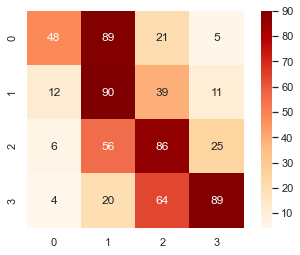

In [368]:
resampling = SMOTE(random_state=0)
model = LogisticRegression()

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

pipeline.fit(Xtrain4, ytrain4) 
predicted = pipeline.predict(Xtest4)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(ytest4, predicted))
conf_mat = confusion_matrix(y_true=ytest4, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest4, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

Classifcation report:
               precision    recall  f1-score   support

         0.0       0.54      0.73      0.62       175
         1.0       0.72      0.47      0.57       360
         2.0       0.49      0.74      0.59       130

    accuracy                           0.59       665
   macro avg       0.58      0.64      0.59       665
weighted avg       0.63      0.59      0.58       665

Confusion matrix:
 [[127  42   6]
 [ 99 168  93]
 [ 11  23  96]]


<AxesSubplot:>

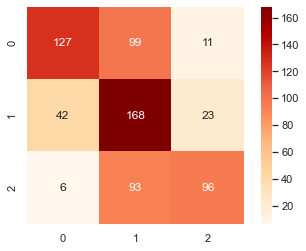

In [369]:
resampling = SMOTE(random_state=0)
model = LogisticRegression()

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

pipeline.fit(Xtrain3, ytrain3) 
predicted = pipeline.predict(Xtest3)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(ytest3, predicted))
conf_mat = confusion_matrix(y_true=ytest3, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest3, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

Classifcation report:
               precision    recall  f1-score   support

         0.0       0.93      0.78      0.85       535
         1.0       0.46      0.77      0.58       130

    accuracy                           0.78       665
   macro avg       0.70      0.78      0.71       665
weighted avg       0.84      0.78      0.80       665

Confusion matrix:
 [[418 117]
 [ 30 100]]


<AxesSubplot:>

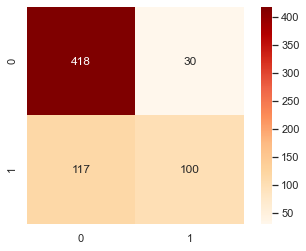

In [370]:
resampling = SMOTE(random_state=0)
model = LogisticRegression()

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

pipeline.fit(Xtrain2, ytrain2) 
predicted = pipeline.predict(Xtest2)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(ytest2, predicted))
conf_mat = confusion_matrix(y_true=ytest2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest2, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

# Recursive Feature Elimination

In [371]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[False  True  True  True False  True False False  True False False  True
 False  True  True False  True  True False  True False False  True  True
 False  True  True  True False False  True False  True  True False False
 False False  True False False]
[ 5  1  1  1 15  1 16 18  1  4 14  1 20  1  1 22  1  1  9  1 19 11  1  1
 17  1  1  1  8 10  1 21  1  1  6 13  2  7  1 12  3]


# Gradient Descent

grid = {
    'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)
bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression, paramGrid,
           Xtrain4, ytrain4, Xtest4, ytest4, 
           metric = roc_auc_score, greater_is_better=True, predict_proba=True,
           scoreLabel = 'AUC')
print(bestModel, bestScore)

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()
    
plot_roc_auc(ytest4 bestModel.predict_proba(Xtest4))

# Hyperparameter Tuning

In [373]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
penalty = ['l2','l1']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [374]:
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(Xtrain4, ytrain4)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l2', 'l1'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

Best: 0.510275 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Classifcation report:
               precision    recall  f1-score   support

         0.0       0.66      0.27      0.38        70
         1.0       0.55      0.75      0.63       255
         2.0       0.44      0.41      0.42       210
         3.0       0.56      0.41      0.47       130

    accuracy                           0.52       665
   macro avg       0.55      0.46      0.48       665
weighted avg       0.53      0.52      0.51       665

Confusion matrix:
 [[ 19  46   5   0]
 [ 10 190  47   8]
 [  0  91  86  33]
 [  0  20  57  53]]


<AxesSubplot:>

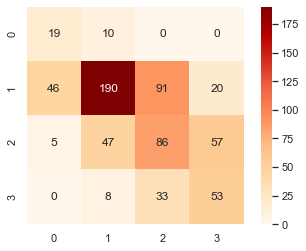

In [375]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
best_grid = grid_search.best_estimator_
ypred = best_grid.predict(Xtest4)

print('Classifcation report:\n', classification_report(ytest4, ypred))
conf_mat = confusion_matrix(y_true=ytest4, y_pred=ypred)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest4, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

y_true = ytest4
y_probas = logreg.predict_proba(Xtest4)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [376]:
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(Xtrain3, ytrain3)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l2', 'l1'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

Best: 0.510275 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Classifcation report:
               precision    recall  f1-score   support

         0.0       0.67      0.53      0.59       175
         1.0       0.63      0.80      0.70       360
         2.0       0.57      0.29      0.39       130

    accuracy                           0.63       665
   macro avg       0.62      0.54      0.56       665
weighted avg       0.63      0.63      0.61       665

Confusion matrix:
 [[ 93  81   1]
 [ 44 288  28]
 [  2  90  38]]


<AxesSubplot:>

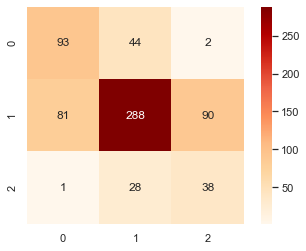

In [377]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
best_grid = grid_search.best_estimator_
ypred = best_grid.predict(Xtest3)

print('Classifcation report:\n', classification_report(ytest3, ypred))
conf_mat = confusion_matrix(y_true=ytest3, y_pred=ypred)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest3, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

In [378]:
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(Xtrain2, ytrain2)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l2', 'l1'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

Best: 0.510275 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Classifcation report:
               precision    recall  f1-score   support

         0.0       0.85      0.95      0.90       535
         1.0       0.60      0.28      0.39       130

    accuracy                           0.82       665
   macro avg       0.72      0.62      0.64       665
weighted avg       0.80      0.82      0.80       665

Confusion matrix:
 [[510  25]
 [ 93  37]]


<AxesSubplot:>

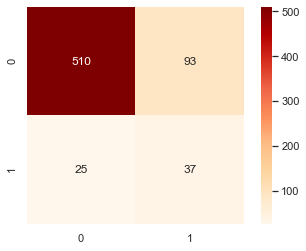

In [379]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
best_grid = grid_search.best_estimator_
ypred = best_grid.predict(Xtest2)

print('Classifcation report:\n', classification_report(ytest2, ypred))
conf_mat = confusion_matrix(y_true=ytest2, y_pred=ypred)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest2, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

# Try PCA

In [403]:
pca = PCA()
pca.fit(Xtrain4)

#Transforming x_train and x_test 
x_train_pca = pca.transform(Xtrain4)
x_test_pca = pca.transform(Xtest4)

#Find number of components that explain predefined variance threshold
sum_variance, component_count = 0, 0
while sum_variance < 0.95:
    sum_variance += pca.explained_variance_ratio_[component_count]
    component_count += 1
    
print('Number of Principal Components that explain >=95% of Variance: ', component_count)
print('Total Variance Explained by '+str(component_count)+' components:', str(sum_variance*100)+'%')

Number of Principal Components that explain >=95% of Variance:  21
Total Variance Explained by 21 components: 95.63695766904222%


In [404]:
#Create and fit PCA object
pca = PCA(n_components=4)
pca.fit(Xtrain4)

#Transforming x_train and x_test 
x_train_pca = pca.transform(Xtrain4)
x_test_pca = pca.transform(Xtest4)

#Add constant to x_train and x_test
x_train_pca_cst = sm.add_constant(x_train_pca)
x_test_pca_cst = sm.add_constant(x_test_pca)

#Training
model = LogisticRegression(C=100000).fit(x_train_pca_cst, ytrain4)

#Predict
y_pred_train = model.predict(x_train_pca_cst)
y_pred_test = model.predict(x_test_pca_cst)

#Perfromance Evaluation
train_score = accuracy_score(ytrain4, y_pred_train)*100
test_score = accuracy_score(ytest4, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 49.22227797290517%
Testing Set Accuracy: 47.81954887218045%


Classifcation report:
               precision    recall  f1-score   support

         0.0       0.56      0.14      0.23        70
         1.0       0.51      0.73      0.60       255
         2.0       0.42      0.36      0.39       210
         3.0       0.45      0.35      0.39       130

    accuracy                           0.48       665
   macro avg       0.48      0.40      0.40       665
weighted avg       0.48      0.48      0.45       665

Confusion matrix:
 [[ 10  53   5   2]
 [  8 187  46  14]
 [  0  95  76  39]
 [  0  32  53  45]]


C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


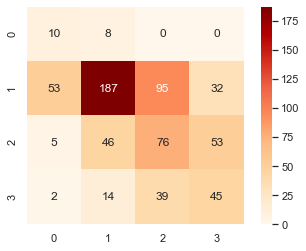

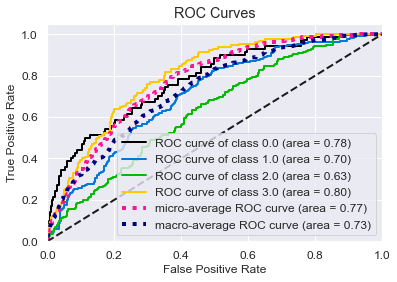

In [406]:
print('Classifcation report:\n', classification_report(ytest4, y_pred_test))
conf_mat = confusion_matrix(y_true=ytest4, y_pred=y_pred_test)
print('Confusion matrix:\n', conf_mat)
mat = confusion_matrix(ytest4, y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

# print(Xtest4.shape)

y_true = ytest4
y_probas = model.predict_proba(x_test_pca_cst)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

Training Set Accuracy: 57.71256583897667%
Testing Set Accuracy: 59.518434913468774%
Classifcation report:
               precision    recall  f1-score   support

         0.0       0.63      0.41      0.50       353
         1.0       0.59      0.84      0.69       709
         2.0       0.55      0.19      0.29       267

    accuracy                           0.60      1329
   macro avg       0.59      0.48      0.49      1329
weighted avg       0.59      0.60      0.56      1329

Confusion matrix:
 [[146 200   7]
 [ 80 593  36]
 [  6 209  52]]


C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


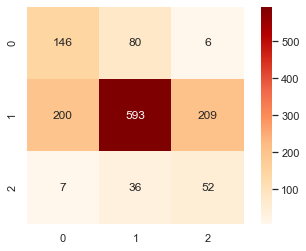

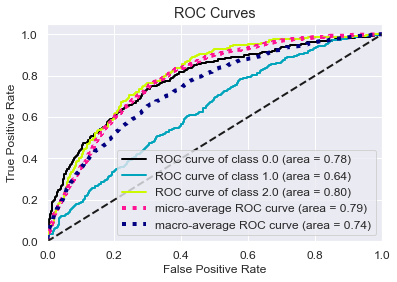

In [407]:
#Create and fit PCA object
pca = PCA(n_components=4)
pca.fit(Xtrain3)

#Transforming x_train and x_test 
x_train_pca = pca.transform(Xtrain3)
x_test_pca = pca.transform(Xtest3)

#Add constant to x_train and x_test
x_train_pca_cst = sm.add_constant(x_train_pca)
x_test_pca_cst = sm.add_constant(x_test_pca)

#Training
model = LogisticRegression(C=100000).fit(x_train_pca_cst, ytrain3)

#Predict
y_pred_train = model.predict(x_train_pca_cst)
y_pred_test = model.predict(x_test_pca_cst)

#Perfromance Evaluation
train_score = accuracy_score(ytrain3, y_pred_train)*100
test_score = accuracy_score(ytest3, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

print('Classifcation report:\n', classification_report(ytest3, y_pred_test))
conf_mat = confusion_matrix(y_true=ytest3, y_pred=y_pred_test)
print('Confusion matrix:\n', conf_mat)
# mat = confusion_matrix(ytest3, predicted)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

y_true = ytest3
y_probas = model.predict_proba(x_test_pca_cst)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

Training Set Accuracy: 82.24228743416103%
Testing Set Accuracy: 80.88788562829194%
Classifcation report:
               precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      1062
         1.0       0.59      0.16      0.26       267

    accuracy                           0.81      1329
   macro avg       0.70      0.57      0.57      1329
weighted avg       0.77      0.81      0.76      1329

Confusion matrix:
 [[1031   31]
 [ 223   44]]


C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


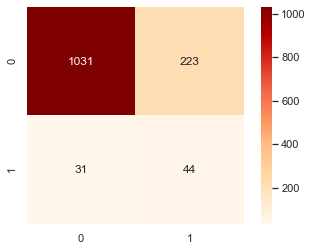

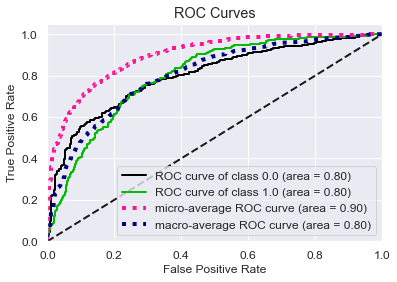

In [408]:
#Create and fit PCA object
pca = PCA(n_components=4)
pca.fit(Xtrain2)

#Transforming x_train and x_test 
x_train_pca = pca.transform(Xtrain2)
x_test_pca = pca.transform(Xtest2)

#Add constant to x_train and x_test
x_train_pca_cst = sm.add_constant(x_train_pca)
x_test_pca_cst = sm.add_constant(x_test_pca)

#Training
model = LogisticRegression(C=100000).fit(x_train_pca_cst, ytrain2)

#Predict
y_pred_train = model.predict(x_train_pca_cst)
y_pred_test = model.predict(x_test_pca_cst)

#Perfromance Evaluation
train_score = accuracy_score(ytrain2, y_pred_train)*100
test_score = accuracy_score(ytest2, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

print('Classifcation report:\n', classification_report(ytest2, y_pred_test))
conf_mat = confusion_matrix(y_true=ytest2, y_pred=y_pred_test)
print('Confusion matrix:\n', conf_mat)
# mat = confusion_matrix(ytest3, predicted)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="OrRd")

y_true = ytest2
y_probas = model.predict_proba(x_test_pca_cst)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# ROC Curve 

(665, 41)


C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


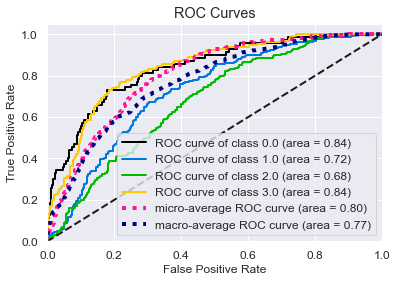

In [399]:
logreg = LogisticRegression()
Xtrain4, Xtest4, ytrain4, ytest4 = train_test_split(data, labels4, random_state=0)
logreg.fit(Xtrain4, ytrain4)

print(Xtest4.shape)

y_true = ytest4
y_probas = logreg.predict_proba(Xtest4)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


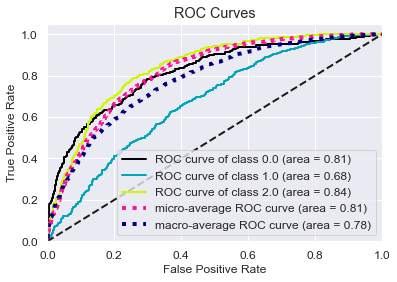

In [393]:
logreg = LogisticRegression()
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(data, labels3, test_size=.5, random_state=0)
logreg.fit(Xtrain3, ytrain3)

y_true = ytest3
y_probas = logreg.predict_proba(Xtest3)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

C:\Users\kinne\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


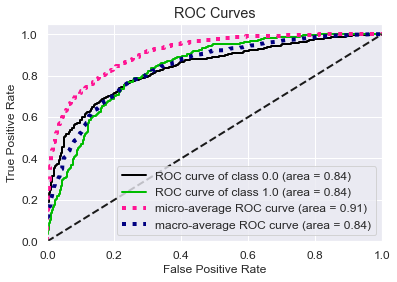

In [394]:
logreg = LogisticRegression()
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(data, labels2, test_size=.5, random_state=0)
logreg.fit(Xtrain2, ytrain2)

y_true = ytest2
y_probas = logreg.predict_proba(Xtest2)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()